## Deep Learning-Based Automated Segmentation of Resection Cavities on Postsurgical Epilepsy MRI
T. Campbell Arnold1,2 *, Ramya Muthukrishnan2,3 *, Akash R. Pattnaik1,2, Nishant Sinha2, Adam Gibson2, Hannah Gonzalez2, Sandhitsu R. Das4, Brian Litt1,2,4, Dario J. Englot5-8, Victoria L. Morgan6-8, Kathryn A. Davis2,4, Joel M. Stein9
*These authors contributed equally
1. Department of Bioengineering, School of Engineering & Applied Science, University of Pennsylvania, Philadelphia, PA, 19104, USA
2. Center for Neuroengineering and Therapeutics, University of Pennsylvania, Philadelphia, PA, 19104, USA
3. Department of Computer Science, University of Pennsylvania, Philadelphia, PA, 19104, USA
4. Department of Neurology, Perelman School of Medicine, University of Pennsylvania, Philadelphia, PA, 19104, USA
5. Department of Neurological Surgery, Vanderbilt University Medical Center, Nashville, Tennessee 37232, USA
6. Department of Radiology and Radiological Sciences, Vanderbilt University Medical Center, Nashville, Tennessee 37232, USA
7. Department of Biomedical Engineering, Vanderbilt University Medical Center, Nashville, Tennessee 37232, USA
8. Institute of Imaging Science, Vanderbilt University Medical Center, Nashville, Tennessee 37232, USA
9. Department of Radiology, Perelman School of Medicine, University of Pennsylvania, Philadelphia, PA, 19104, USA



#### Synopsis
We present a tool for automatic resection cavity segmentation on postoperative MRI of temporal lobe epilepsy patients. Applications include quantification of postoperative remnant brain volumes, correction of deformable registration, and localization of removed brain regions for network modeling.


## Abstract

Accurate segmentation of surgical resection sites is critical for clinical assessments and neuroimaging research applications, including resection extent determination, predictive modeling of surgery outcome, and masking image processing near resection sites. In this study, an automated resection cavity segmentation algorithm is developed for analyzing postoperative MRI of epilepsy patients and deployed in an easy-to-use graphical user interface (GUI) that estimates remnant brain volumes, including postsurgical hippocampal remnant tissue. This retrospective study included postoperative T1-weighted MRI from 62 temporal lobe epilepsy (TLE) patients who underwent resective surgery. The resection site was manually segmented and reviewed by a neuroradiologist (JMS). A majority vote ensemble algorithm was used to segment surgical resections, using 3 U-Net convolutional neural networks trained on axial, coronal, and sagittal slices, respectively. The algorithm was trained using 5-fold cross validation, with data partitioned into training (N = 27) testing (N = 9), and validation (N = 9) sets, and evaluated on a separate held-out test set (N = 17). Algorithm performance was assessed using Dice-Sørensen coefficient (DSC), Hausdorff distance, and volume estimates. Additionally, we deploy a fully-automated, GUI-based pipeline that compares resection segmentations with preoperative imaging and reports estimates of resected brain structures. The cross-validation and held-out test median DSCs were 0.84 ± 0.08 and 0.74 ± 0.22 (median ± interquartile range) respectively, which approach inter-rater reliability between radiologists (0.84 - 0.86) as reported in the literature. Median 95% Hausdorff distances were 3.6 mm and 4.0 mm respectively, indicating high segmentation boundary confidence. Automated and manual resection volume estimates were highly correlated for both cross-validation (r = 0.94, p < 0.0001) and held-out test subjects (r = 0.87, p < 0.0001). Automated and manual segmentations overlapped in all 62 subjects, indicating a low false negative rate. In control subjects (N = 40), the classifier segmented no voxels (N = 33), less than 50 voxels (N = 5), or a small volumes less than 0.5 cm3 (N = 2), indicating a low false positive rate that can be controlled via thresholding. There was strong agreement between postoperative hippocampal remnant volumes determined using automated and manual resection segmentations (r = 0.90, p < 0.0001, mean absolute error = 6.3%), indicating that automated resection segmentations can permit quantification of postoperative brain volumes after epilepsy surgery. Applications include quantification of postoperative remnant brain volumes, correction of deformable registration, and localization of removed brain regions for network modeling.


## 1. Introduction

Epilepsy is a neurological disorder characterized by recurrent seizures, affecting sixty-five million people worldwide (1). Temporal lobe epilepsy (TLE) is the most common form of epilepsy, with a prevalence of 8.9 cases per 100,000 people per year in the US (2). Surgical removal of the epileptic focus is the recommended treatment for drug-resistant TLE, however only about 60% of patients experience seizure-freedom one year postoperatively (3–7). A variety of approaches have been used to better predict surgical outcome, including quantitative assessments of resection extent (8–10) and modelling the surgical procedure on preoperative functional or structural networks (10,11). However, many of these methods rely on manual segmentation of the resection zone and automated methods for quantifying resection extent would be of significant interest to the epilepsy clinical and neuroimaging research communities.

Retrospective studies attempting to predict surgical outcome of TLE patients use a variety of manual methods which are susceptible to bias due to inter-rater variability. Simple measures, like the inclusion of particular brain structures, particularly the hippocampus, in the resection zone, have been identified as positive predictors of postoperative seizure freedom (9,12). More complex methods mimic surgical resection on brain network models to predict postoperative seizure freedom (13,14). The resected brain regions are often determined through manual segmentation or visual inspection (11,15). Time-consuming and error-prone manual methods for determining resected tissue limit clinical adoption of these tools. An automated method for delineating resection cavities would be of substantial clinical and research interest, with potential to increase the accuracy of predictive models, evaluate alternative surgical strategies, and improve patient outcomes.

Recent advances in convolutional neural networks (CNNs) have led to vast improvements in classification and segmentation of medical imaging (16). Neural network architectures designed for segmentation, such as U-Nets, have been successfully applied to problems from a wide range of specialties, including radiology, pathology, and dermatology (17). Additionally, new deep-learning enabled neuroimaging software packages have dramatically reduced processing time for tasks such as brain parcellation (18). A primary goal for many of these tools is the automation of tedious, time-consuming tasks in medicine (19). In epilepsy patient care, predictive models of resection extent have not been adopted clinically in part due to their reliance on manual segmentation of resections or visual inspection by researchers, which is time-consuming and variable across individuals and institutions. The lack of automated resection segmentation methods prevents quantitative neuroimaging analyses from being integrated into epilepsy patient care (20).

Therefore, the goal of our study was to develop a fully automated method for segmenting resection volumes and quantifying resected brain tissues, particularly hippocampal remnant volumes, in TLE patients. This tool can evaluate successful removal of surgical targets and has potential to improve predictive models of surgical outcome. Additionally, we present a graphical user interface (GUI) that allows users who are not familiar with machine learning to easily apply the model to their data. We demonstrate that the model can segment the resection zone and estimate which brain regions were removed in under 5 minutes, permitting easy integration into a clinical workflow. We openly share all code, including the machine learning model, GUI, and statistical analyses to facilitate clinical translation of our work.


## Import python modules

In [1]:
%%capture

# !pip install xlrd
# !pip install antspyx==0.2.9 # install ANTs python
# !pip install antspynet==0.1.3 # install ANTs python networks (for longitudinal cortical thickness)
# !pip install tensorflow==2.6.2
# !pip install keras==2.6.0
# !pip install seaborn==0.11.2

# import relevant modules
import ants
import numpy as np
import seaborn as sns
import scipy
import scipy.stats as stats
from scipy.stats import ttest_rel
import matplotlib.pyplot as plt
import sklearn
import pandas as pd
import os
import tensorflow as tf
import antspynet
import shutil

In [2]:
%%capture

# Update OpenSSL for python 3.6.0
# https://stackoverflow.com/questions/42098126/mac-osx-python-ssl-sslerror-ssl-certificate-verify-failed-certificate-verify
#

!pip install certifi

# sample script to install or update a set of default Root Certificates
# for the ssl module.  Uses the certificates provided by the certifi package:
# https://pypi.python.org/pypi/certifi
import os.path
import ssl
import stat
import subprocess
import sys
import certifi

STAT_0o775 = ( stat.S_IRUSR | stat.S_IWUSR | stat.S_IXUSR
             | stat.S_IRGRP | stat.S_IWGRP | stat.S_IXGRP
             | stat.S_IROTH |                stat.S_IXOTH )
def main():
    openssl_dir, openssl_cafile = os.path.split(
        ssl.get_default_verify_paths().openssl_cafile)
    print(" -- pip install --upgrade certifi")
    subprocess.check_call([sys.executable,
        "-E", "-s", "-m", "pip", "install", "--upgrade", "certifi"])
    import certifi
    # change working directory to the default SSL directory
    os.chdir(openssl_dir)
    relpath_to_certifi_cafile = os.path.relpath(certifi.where())
    print(" -- removing any existing file or link")
    try:
        os.remove(openssl_cafile)
    except FileNotFoundError:
        pass
    print(" -- creating symlink to certifi certificate bundle")
    os.symlink(relpath_to_certifi_cafile, openssl_cafile)
    print(" -- setting permissions")
    os.chmod(openssl_cafile, STAT_0o775)
    print(" -- update complete")
if __name__ == '__main__':
    main()
    os.chdir(r'/Users/tcarnold/Desktop/Everything/CNT/Projects/DeepResection/scripts') 

## Helper Functions

In [3]:
def iqr(x):
    iqr = np.subtract(*np.percentile(x, [75, 25]))
    
    return iqr

In [4]:
# for comparing continuous stats across sites
def basic_stats(df,var):
    
    print(var)
    print('Mean (std): ' + str( np.round( np.mean( df[var] ) , 2 ) ) + ' +/- ' + str( np.round( np.std( df[var]) , 2 ) ) )
    print('Median (IQR): ' + str( np.round( np.median( df[var] ) , 2 ) ) + ' +/- ' + str( np.round( iqr(df[var]) , 2 ) ) )
    print('Max: ' + str( np.round( np.max( df[var] ) , 2 ) ) )
    print('Min: ' + str( np.round( np.min( df[var] ) , 2 ) ) )
    print()


In [5]:
# For comparing ATL and SAH
def compare_stats(df1,label1,df2,label2,var):
    
    print(var)
    print(label1)
    print('Mean (std): ' + str( np.round( np.mean( df1[var] ) , 2 ) ) + ' +/- ' + str( np.round( np.std( df1[var]) , 2 ) ) )
    print('Median (IQR): ' + str( np.round( np.median( df1[var] ) , 2 ) ) + ' +/- ' + str( np.round( iqr( df1[var]) , 2 ) ) )
    print('Max: ' + str( np.round( np.max( df1[var] ) , 2 ) ) )
    print('Min: ' + str( np.round( np.min( df1[var] ) , 2 ) ) )
    print(label2)
    print('Mean (std): ' + str( np.round( np.mean( df2[var] ) , 2 ) ) + ' +/- ' + str( np.round( np.std( df2[var]) , 2 ) ) )
    print('Median (IQR): ' + str( np.round( np.median( df2[var] ) , 2 ) ) + ' +/- ' + str( np.round( iqr( df2[var]) , 2 ) ) )
    print('Max: ' + str( np.round( np.max( df2[var] ) , 2 ) ) )
    print('Min: ' + str( np.round( np.min( df2[var] ) , 2 ) ) )
    ttest_results = scipy.stats.ttest_ind( df1[var], df2[var], nan_policy='omit')
    print(ttest_results)
    print()
    

In [6]:
# discrete chi squared analysis
def chi_sq_test(df,var):

    crosstab = pd.crosstab(df["site"], df[var])
    results = stats.chi2_contingency(crosstab)
    print('X^2 = ' + str(results[0]) + ', p = ' + str(results[1]))
    

## 2. Materials and Methods

#### 2.1. Data collection

For model training and cross-validation, T1-weighted images (N = 45) were collected from temporal lobe epilepsy (TLE) patients that underwent surgery at the Hospital of the University of Pennsylvania (HUP) or Vanderbilt University Medical Center (VUMC). Internal Review Boards of each institution approved this study, and all patients gave informed consent. Patients at HUP (N = 22) were imaged primarily using a Siemens 3T scanner with the following T1-weighted sequence parameters: 1mm isotropic, TE = 3.87ms, TR = 1.62s, and flip-angle = 15. Patients at VUMC (N = 23) were imaged using a Phillips 3T scanner and T1-weighted sequence parameters were 1mm isotropic, TE = 4.61ms, TR = 8.9ms, and flip-angle = 8. All images were collected at least 5 months postoperatively to avoid peri-surgical swelling. Inclusion criteria were: 1) TLE patients who underwent resection or ablation, 2) whole-brain, isotropic T1-weighted imaging at least 5 months postoperatively, and 3) only one contiguous resection site. Preoperative T1-weighted imaging using the same scanner and sequence parameters were available for 36 of the 45 patients.

After initial model development, we aggregated additional data to evaluate model performance on a held-out test set and tune the algorithm for use in extratemporal patients. For the held-out test set, we collected 17 T1-weighted images from TLE patients. To tune the model to extratemporal patients, we collected 16 T1-weighted images from patients with resections outside the temporal lobe. To increase sample size, our inclusion criteria for these two sets were relaxed to allow for anisotropic imaging, partial fields of view, and patients with multiple surgical sites. Additionally, we collected a control dataset (N=40) consisting of T1-weighted images from participants at HUP (N=20) and VUMC (N=20). Each institution’s control set contained 10 preoperative images from TLE patients (i.e. patients without a resection) and 10 images from healthy participants.

#### 2.2. Data preprocessing

The resection site in each postoperative T1-weighted image was manually segmented in ITK-SNAP (21) and reviewed by a board certified neuroradiologist with 8 years of experience (JMS). Each 3D volumetric image was normalized to a standard intensity range [0-1], and 2D slices in each view (axial, coronal, and sagittal) were output as 256x256 Portable Networks Graphic (PNG) files for training.

#### 2.3. Model Architecture

A majority vote ensemble algorithm using three models trained separately on axial, coronal, and sagittal slices, respectively, was used to segment resections. In the majority vote ensemble, a voxel would be included in the segmentation if it was labeled by at least 2 of the 3 classifiers (i.e. 2+ votes). The same U-Net CNN architecture was used to train each model (17). Model construction and training was carried out using the Keras API with TensorFlow backend (22). The model training script was adapted from an open-source U-net segmentation project (23) to our model architecture and run on an independent server using a Titan-X GPU. The U-Net architecture consists of an encoder that captures contextual information and a decoder that captures localization information to output a predicted mask. Our model architecture replaced the traditional U-Net encoder with the EfficientNet B1 network encoder backbone, and initial encoder weights were pre-trained on ImageNet data (24,25).

#### 2.4. Model Training

Each model performed binary segmentation of resections (i.e. 1 = resected, 0 = not resected) on axial, coronal, or sagittal slices of T1-weighted images. During model training, 5-fold cross-validation was employed with data divided into training, validation, and test sets (3:1:1 split). All 2D slices for a given subject were contained within a single set (i.e. training, validation, or testing). The 5-fold approach permits each subject in the dataset to be included in the held-out test set once. Models were trained for 50 epochs using the Adam optimizer, a learning rate of 1e-4, and a batch size of 16. Data augmentation was employed during training to increase model generalizability (26). Augmentation included random horizontal and vertical flips, rotations up to 10 degrees, and horizontal and vertical shifts up to 10% of image width and height.

#### 2.5. Post processing

Segmentations output by the CNN underwent three post processing steps: 1) assembly of 3D volumes from 2D slice segmentations, 2) majority vote to combine axial, sagittal, and coronal, segmentations, and 3) connected components analysis to remove isolated voxels.

#### 2.6. Model Evaluation

Performance was evaluated across all cross-validation folds as well as the held-out test dataset. Segmentation performance was primarily evaluated using the Dice-Sørensen coefficient (DSC) (27). DSC measures the overlap between manual segmentations X and automated segmentations Y (Figure 1), by computing: DSC = 2|X∩Y|/(|X|+|Y|). Performance for DSC ranges from 0 (no overlap) to 1 (perfect match). Hyperparameter optimization was driven by DSC maximization in the validation set. To assess model generalizability to novel images, all reported DSCs were calculated on held-out test datasets.

Subtle changes to performance measures can result in significant differences when ranking algorithms (28). To provide a holistic view of model performance, we report multiple metrics and descriptive statistics. We report two secondary measures, Hausdorff distance and total resection volume (Figure 1). Hausdorff distance compares actual and predicted segmentation boundaries and reports the distances between adjacent boundary points. This measure characterizes the segmentation border reliability. Several variants of the Hausdorff distance are reported in the literature (29,30); we report the 95% Hausdorff distance, which is more robust to outliers. Additionally, the relationship between manual and automated resection volumes was plotted for each subject and we report the Pearson’s correlation coefficient and mean absolute error (MAE) between these variables.

#### 2.7. Model tuning to extratemporal cases

In initial model development, we constrained our target population to only patients with temporal lobe resections. While the temporal lobe is the most common surgical site, epilepsy patients can also have frontal, parietal, and occipital lobe resections. In an exploratory analysis, we tuned our model to perform extratemporal segmentations using a limited dataset of 16 cases (frontal: N = 10, parietal: N = 7, temporal: N =3, occipital: N = 1, Note: some cases have multiple resections). Patients were separated into training (N = 10) and testing (N = 6) sets. The temporal lobe segmentation model weights were unfrozen and retrained for 50 epochs using the Adam optimizer, a learning rate of 1e-4, and a batch size of 16. All reported metrics were assessed on the held-out test set.

#### 2.8. Quantifying surgical remnants

Postoperative remnant volumes, such as the hippocampal remnant, have predictive value for TLE surgical outcome (12). We further developed a pipeline that estimates postoperative remnant brain structures. The pipeline takes a patient’s preoperative and postoperative T1 brain MRI as input and generates a PDF report or an interactive web-based report of estimated resection impact on brain structures (Figure 2). Preoperative imaging was coregistered to post-operative imaging and segmented into brain regions using the Desikan–Killiany–Tourville (DKT) atlas with subcortical parcellations using the deep-learning enabled toolkit, Advanced Normalization Tools Python (ANTsPyNet) (18,31,32). Images were coregistered using a symmetric normalization transformation, with cross-correlation as optimization metric and cost-function masking of the resection zone to mitigate image distortion (33). Proper image coregistration was verified manually and any subjects with significant distortion (N=1) were excluded. The resection cavity was segmented both manually and using the automated algorithm described here for comparison. The intersection of preoperative brain segmentations and the postoperative resection segmentation was used to estimate remnant brain volumes. We correlated hippocampal remnant volume estimates between manual and automated resection segmentation methods. The postsurgical hippocampal remnant tissue was not manually segmented, but rather estimated using the manual resection segmentation.

#### 2.9. Code availability

All code related to model design and postoperative volume estimation can be found at: https://github.com/penn-cnt/DeepResection. Code related to statistical analysis can be found at: https://github.com/penn-cnt/DeepResection_Statistical_Analysis. 

## 3. Results



#### 3.1. Patient characteristics

Our main dataset included 45 patients who underwent surgery for localization-related epilepsy across two institutions, Hospital of the University of Pennsylvania (HUP, N = 22) and Vanderbilt University Medical Center (VUMC, N = 23). Patients were age-matched across institution (HUP: 39.2 ± 12.0 years, VUMC: 39.5 ± 12.7 years) and were treated with either anterior temporal lobectomy (ATL, N=28), selective amygdalohippocampectomy (SAH, N=15), or hippocampal laser interstitial thermal therapy (LITT, N=2). There was no significant difference between institutions for the patients’ gender, age of seizure onset, age at surgery, side of seizure surgery, age at scan, or disease duration. There was a significant difference in the surgical approach between institutions (X2 = 21.99, p < 0.0001, chi-square test), as patients were only treated with SAH at one center. Demographic information is provided in Table 1.


In [255]:
# load in patient demographic information

demo_df = pd.read_csv('../data/clinical_info.csv')
demo_df = demo_df.drop(columns=['RID']) # remove internal ID number

# print number of subjects from each epilepsy center
HUP_N = np.sum(demo_df['site'] == 'HUP')
VUMC_N = np.sum(demo_df['site'] == 'VUMC')
print('HUP N: ' + str(HUP_N) +'\nVUMC N: ' + str(VUMC_N))

HUP N: 22
VUMC N: 23


In [256]:
# summarize demographic information
demo_result = demo_df.agg({'age at surgery': ['mean', 'std'], \
                                      'age at scan': ['mean', 'std'], \
                                      'age at onset': ['mean', 'std'], \
                                      'duration': ['mean', 'std']}).round(1)
demo_result

,age at surgery,age at scan,age at onset,duration
mean,37.1,39.3,19.1,19.9
std,12.1,12.2,11.6,14.1


In [257]:
# demographics by center
demo_result = demo_df.groupby('site').agg({'age at surgery': ['mean', 'std'], \
                                      'age at scan': ['mean', 'std'], \
                                      'age at onset': ['mean', 'std'], \
                                      'duration': ['mean', 'std']}).round(1)
demo_result

age at surgery       age at scan       age at onset       duration      
               mean   std        mean   std         mean   std     mean   std
site                                                                         
HUP            37.5  11.5        39.2  12.0         19.5  10.6     15.6   8.7
VUMC           36.6  12.8        39.5  12.7         18.9  12.2     21.8  15.7

In [258]:
# demographics - sex
chi_sq_test(demo_df,'gender')

demo_df.groupby(['site','gender']).size().unstack(fill_value=0)

X^2 = 1.240995657156144, p = 0.2652792526674132


gender,Female,Male
site,,
HUP,16,6
VUMC,12,11


In [259]:
# demographics - surgical approach
chi_sq_test(demo_df,'surgery')

demo_df.groupby(['site','surgery']).size().unstack(fill_value=0)


X^2 = 19.81514924356004, p = 4.979606357283673e-05


surgery,ATL,LITT,SAH
site,,,
HUP,21,1,0
VUMC,8,1,14


In [260]:
# demographics - side of surgery
chi_sq_test(demo_df,'side')

demo_df.groupby(['site','side']).size().unstack(fill_value=0)

X^2 = 1.8127065549539962, p = 0.178183893948966


side,Left,Right
site,,
HUP,11,11
VUMC,6,17


In [261]:
# compare demographic variables between sites
HUP_df = demo_df[ demo_df['site'] == 'HUP' ]
VUMC_df = demo_df[ demo_df['site'] == 'VUMC' ]

# compare continuous variables
compare_stats(HUP_df,'HUP',VUMC_df,'VUMC','age at surgery')
compare_stats(HUP_df,'HUP',VUMC_df,'VUMC','age at onset')
compare_stats(HUP_df,'HUP',VUMC_df,'VUMC','age at scan')
compare_stats(HUP_df,'HUP',VUMC_df,'VUMC','duration')


age at surgery
HUP
Mean (std): 37.55 +/- 11.21
Median (IQR): 40.0 +/- 13.5
Max: 67.0
Min: 18.0
VUMC
Mean (std): 36.59 +/- 12.55
Median (IQR): 35.33 +/- 12.5
Max: 65.92
Min: 13.92
Ttest_indResult(statistic=0.2617100686030439, pvalue=0.7947945597176789)

age at onset
HUP
Mean (std): 19.5 +/- 10.09
Median (IQR): nan +/- nan
Max: 37.0
Min: 1.0
VUMC
Mean (std): 18.91 +/- 11.94
Median (IQR): 20.0 +/- 22.5
Max: 33.0
Min: 0.25
Ttest_indResult(statistic=0.1332566241828901, pvalue=0.894851721272365)

age at scan
HUP
Mean (std): 39.2 +/- 11.74
Median (IQR): nan +/- nan
Max: 69.0
Min: 19.0
VUMC
Mean (std): 39.48 +/- 12.38
Median (IQR): 39.0 +/- 13.0
Max: 68.0
Min: 18.0
Ttest_indResult(statistic=-0.07350861098568376, pvalue=0.9417588545498137)

duration
HUP
Mean (std): 15.6 +/- 8.3
Median (IQR): nan +/- nan
Max: 28.0
Min: 2.0
VUMC
Mean (std): 21.83 +/- 15.38
Median (IQR): 18.0 +/- 26.5
Max: 50.0
Min: 2.0
Ttest_indResult(statistic=-1.1687251068870603, pvalue=0.25142354998930855)



#### 3.2 Primary performance measure (DSC)

The majority vote model was trained using 5-fold cross-validation and accuracy is reported using the per-scan DSC for held out subjects in the cross-validation test sets (Table 2). The average test DSC across all scans was 0.82 ± 0.07 (mean ± standard deviation), with a median DSC of 0.84 and interquartile range of 0.08 (Figure 3A). The maximum DSC achieved by the classifier for a given patient was 0.92, while the minimum score was 0.58. To illustrate the range of segmentation quality, Figure 3D shows examples of manual segmentations and corresponding predicted labels at each quartile of the DSC distribution. The majority vote classifier modestly outperformed individual axial, sagittal, and coronal classifiers as well as more stringent or relaxed voting schemes (Figure S1).

###### Majority vote versus individual classifiers

In [282]:
# load data
subs = np.load('../analysis/final_results/results/main/patient_list.npy')
dice_axi = np.load('../analysis/final_results/results/main/dice_scores_axial.npy')
dice_sag = np.load('../analysis/final_results/results/main/dice_scores_sagittal.npy')
dice_cor = np.load('../analysis/final_results/results/main/dice_scores_coronal.npy')
dice_v1 = np.load('../analysis/final_results/results/main/dice_scores_vote_1.npy')
dice_v2 = np.load('../analysis/final_results/results/main/dice_scores_vote_2.npy')
dice_v3 = np.load('../analysis/final_results/results/main/dice_scores_vote_3.npy')

# make dataframe
DSC_MV_df =pd.DataFrame({'subID': subs,
                         'Axial': dice_axi,
                         'Sagittal': dice_sag,
                         'Coronal': dice_cor,
                         '1+ Votes': dice_v1,
                         '2+ Votes': dice_v2,
                         '3 Votes': dice_v3})
#                           'Dice Score (Axial)': dice_axi,
#                           'Dice Score (Sagittal)': dice_sag,
#                           'Dice Score (Coronal)': dice_cor,
#                           'Dice Score (1+ Votes)': dice_v1,
#                           'Dice Score (2+ Votes)': dice_v2,
#                           'Dice Score (3 Votes)': dice_v3})
DSC_MV_df.sort_values(by='Axial')

,subID,Axial,Sagittal,Coronal,1+ Votes,2+ Votes,3 Votes
20,HUP142,0.356414,0.720967,0.599862,0.732952,0.615314,0.304000
32,pat14,0.551793,0.734880,0.752160,0.542703,0.788720,0.720606
41,pat26,0.569524,0.741568,0.692570,0.810781,0.664224,0.483592
25,pat05,0.571123,0.735178,0.739218,0.580074,0.740304,0.746723
40,pat25,0.633388,0.773121,0.575699,0.772000,0.741818,0.415743
6,29_w,0.652438,0.520286,0.566912,0.713793,0.581804,0.372152
14,HUP065,0.662790,0.906080,0.565705,0.906354,0.782182,0.381922
7,30_m,0.666236,0.809960,0.734704,0.683408,0.767726,0.760470
33,pat15,0.685164,0.725313,0.729744,0.614510,0.759355,0.810245
31,pat13,0.705601,0.713228,0.793388,0.824036,0.750495,0.619188


In [303]:
# print DSC basic stats
basic_stats(DSC_MV_df,'Axial')
basic_stats(DSC_MV_df,'Sagittal')
basic_stats(DSC_MV_df,'Coronal')
basic_stats(DSC_MV_df,'1+ Votes')
basic_stats(DSC_MV_df,'2+ Votes')
basic_stats(DSC_MV_df,'3 Votes')

Axial
Mean (std): 0.78 +/- 0.11
Median (IQR): 0.81 +/- 0.11
Max: 0.92
Min: 0.36

Sagittal
Mean (std): 0.81 +/- 0.07
Median (IQR): 0.82 +/- 0.08
Max: 0.91
Min: 0.52

Coronal
Mean (std): 0.79 +/- 0.09
Median (IQR): 0.82 +/- 0.1
Max: 0.91
Min: 0.57

1+ Votes
Mean (std): 0.81 +/- 0.08
Median (IQR): 0.83 +/- 0.08
Max: 0.91
Min: 0.54

2+ Votes
Mean (std): 0.82 +/- 0.07
Median (IQR): 0.84 +/- 0.08
Max: 0.92
Min: 0.58

3 Votes
Mean (std): 0.75 +/- 0.15
Median (IQR): 0.79 +/- 0.11
Max: 0.9
Min: 0.3



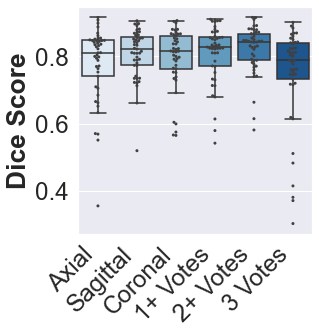

In [300]:
# boxplot of DSC
sns.set(font_scale = 2.2)
fig = plt.figure(figsize = (5,5)) # create a 5 x 5 figure 
ax = sns.boxplot(data=DSC_MV_df, orient="v", palette=sns.color_palette("Blues"), fliersize=0)
ax = sns.swarmplot(data=DSC_MV_df, orient="v", color=".25", size=3)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
# plt.axis([-0.75,5.75,0,1])


plt.ylabel('Dice Score',fontweight = 'bold')
plt.gcf().subplots_adjust(left=0.25, bottom=0.25)
plt.savefig('../output/figures_NeuroImage_clinical/Supp_figure_majority_vote_DSC.tiff',
           dpi=300)

###### Model performance by fold

In [313]:
subs = np.load('../analysis/final_results/results/main/patient_list.npy')
DSC_fold1 = load_json_test('../analysis/final_results/results/main/Dice_by_fold.json','fold1')
DSC_fold2 = load_json_test('../analysis/final_results/results/main/Dice_by_fold.json','fold2')
DSC_fold3 = load_json_test('../analysis/final_results/results/main/Dice_by_fold.json','fold3')
DSC_fold4 = load_json_test('../analysis/final_results/results/main/Dice_by_fold.json','fold4')
DSC_fold5 = load_json_test('../analysis/final_results/results/main/Dice_by_fold.json','fold5')
HD95_fold1 = load_json_test('../analysis/final_results/results/main/hd95_by_fold.json','fold1')
HD95_fold2 = load_json_test('../analysis/final_results/results/main/hd95_by_fold.json','fold2')
HD95_fold3 = load_json_test('../analysis/final_results/results/main/hd95_by_fold.json','fold3')
HD95_fold4 = load_json_test('../analysis/final_results/results/main/hd95_by_fold.json','fold4')
HD95_fold5 = load_json_test('../analysis/final_results/results/main/hd95_by_fold.json','fold5')
folds_df =pd.DataFrame({ 
                          'DSC (Fold 1)': DSC_fold1,
                          'DSC (Fold 2)': DSC_fold2,
                          'DSC (Fold 3)': DSC_fold3,
                          'DSC (Fold 4)': DSC_fold4,
                          'DSC (Fold 5)': DSC_fold5,
                          'HD95 (Fold 1)': HD95_fold1,
                          'HD95 (Fold 2)': HD95_fold2,
                          'HD95 (Fold 3)': HD95_fold3,
                          'HD95 (Fold 4)': HD95_fold4,
                          'HD95 (Fold 5)': HD95_fold5})
folds_df

# print out results
basic_stats(folds_df,'DSC (Fold 1)')
basic_stats(folds_df,'DSC (Fold 2)')
basic_stats(folds_df,'DSC (Fold 3)')
basic_stats(folds_df,'DSC (Fold 4)')
basic_stats(folds_df,'DSC (Fold 5)')
basic_stats(folds_df,'HD95 (Fold 1)')
basic_stats(folds_df,'HD95 (Fold 2)')
basic_stats(folds_df,'HD95 (Fold 3)')
basic_stats(folds_df,'HD95 (Fold 4)')
basic_stats(folds_df,'HD95 (Fold 5)')

DSC (Fold 1)
Mean (std): 0.81 +/- 0.1
Median (IQR): 0.85 +/- 0.15
Max: 0.92
Min: 0.62

DSC (Fold 2)
Mean (std): 0.82 +/- 0.05
Median (IQR): 0.83 +/- 0.1
Max: 0.88
Min: 0.74

DSC (Fold 3)
Mean (std): 0.83 +/- 0.1
Median (IQR): 0.85 +/- 0.03
Max: 0.92
Min: 0.58

DSC (Fold 4)
Mean (std): 0.82 +/- 0.04
Median (IQR): 0.83 +/- 0.06
Max: 0.88
Min: 0.77

DSC (Fold 5)
Mean (std): 0.83 +/- 0.03
Median (IQR): 0.83 +/- 0.04
Max: 0.88
Min: 0.77

HD95 (Fold 1)
Mean (std): 5.78 +/- 3.66
Median (IQR): 4.0 +/- 6.23
Max: 11.85
Min: 1.95

HD95 (Fold 2)
Mean (std): 3.79 +/- 1.45
Median (IQR): 2.96 +/- 2.2
Max: 6.64
Min: 2.24

HD95 (Fold 3)
Mean (std): 3.64 +/- 1.44
Median (IQR): 3.55 +/- 1.6
Max: 7.09
Min: 2.24

HD95 (Fold 4)
Mean (std): 4.73 +/- 2.2
Median (IQR): 4.0 +/- 1.94
Max: 9.76
Min: 2.23

HD95 (Fold 5)
Mean (std): 5.72 +/- 3.95
Median (IQR): 3.66 +/- 4.0
Max: 13.0
Min: 2.0



#### Primary performance measure (DSC)

The majority vote model was trained using 5-fold cross-validation and accuracy is reported using the per-scan DSC for held out subjects in the cross-validation test sets (Table 2). The average test DSC across all scans was 0.82 ± 0.07 (mean ± standard deviation), with a median DSC of 0.84 and interquartile range of 0.08 (Figure 3A). The maximum DSC achieved by the classifier for a given patient was 0.92, while the minimum score was 0.58. To illustrate the range of segmentation quality, Figure 3D shows examples of manual segmentations and corresponding predicted labels at each quartile of the DSC distribution. The majority vote classifier modestly outperformed individual axial, sagittal, and coronal classifiers as well as more stringent or relaxed voting schemes (Figure S1).

In [222]:
# used to sort ground truth volumes
resort_index = [22 ,3 ,15 ,12 ,10 ,44 ,39 ,17 ,25 ,29 ,5 ,41 ,26 ,38 ,21 ,19 ,6 ,20 ,11 ,30 ,9 ,4 ,40 ,37 ,7 ,27 ,35 ,8 ,42 ,31 ,32 ,18 ,16 ,24 ,36 ,13 ,0 ,33 ,23 ,1 ,2 ,28 ,34 ,43 ,14]

In [263]:
# load data
pred_vol = np.load('../analysis/final_results/results/main/pred_volumes.npy')
gt_vol = np.load('../analysis/final_results/results/main/truth_volumes.npy')
# gt_vol = gt_vol[resort_index] # gt_volumes_clean.npy is not properly order, so needs sorting
dice = np.load('../analysis/final_results/results/main/dice_scores_vote_2.npy')
subs = np.load('../analysis/final_results/results/main/patient_list.npy')
hd50 = np.load('../analysis/final_results/results/main/hd50.npy')
hd95 = np.load('../analysis/final_results/results/main/hd95.npy')

# make dataframe
results_df =pd.DataFrame({'subID': subs, 
                          'Predicted Volume (ml)': pred_vol,
                          'Ground Truth Volume (ml)': gt_vol,
                          'Dice Score': dice,
                          '50% Hausdorff Distance (mm)': hd50,
                          '95% Hausdorff Distance (mm)': hd95})
results_df.sort_values(by='Dice Score')

,subID,Predicted Volume (ml),Ground Truth Volume (ml),Dice Score,50% Hausdorff Distance (mm),95% Hausdorff Distance (mm)
6,29_w,15.934944,34.620285,0.581804,1.381068,7.094524
20,HUP142,1.084482,2.345361,0.615314,1.299579,11.849110
41,pat26,3.953000,7.510000,0.664224,1.000000,9.695360
25,pat05,7.674000,6.223000,0.740304,1.000000,3.605551
40,pat25,2.563000,3.487000,0.741818,1.000000,3.464102
31,pat13,2.329000,3.731000,0.750495,1.000000,3.605551
33,pat15,5.302000,3.624000,0.759355,1.000000,2.236068
7,30_m,42.764664,36.686897,0.767726,0.976562,7.000000
19,HUP106,12.312889,18.715858,0.771392,1.000000,6.835938
30,pat11,29.136000,19.750000,0.776664,1.000000,5.477226


In [264]:
# print DSC basic stats
basic_stats(results_df,'Dice Score')


Dice Score
Mean (std): 0.82 +/- 0.07
Median (IQR): 0.84 +/- 0.08
Max: 0.92
Min: 0.58



### Figure 3A

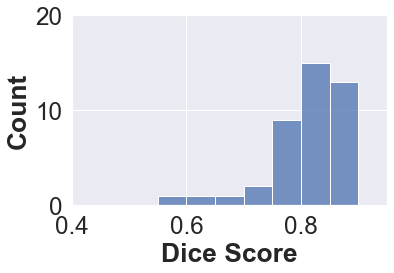

In [265]:
# histogram distribution of DSC
sns.set_context("paper")
sns.set(font_scale = 2.2)
ax = sns.histplot(results_df['Dice Score'],binwidth=0.05, binrange=[0.45,.9])
plt.axis([0.4, 0.95 , 0, 20])
plt.ylabel('Count',fontweight = 'bold')
plt.xlabel('Dice Score',fontweight = 'bold')
plt.gcf().subplots_adjust(bottom=0.22, left=0.17)
plt.savefig('../output/figures_NeuroImage_clinical/figure_2A.tiff',
           dpi=300)

### Figure 3D

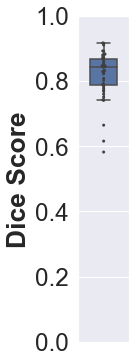

In [266]:
# boxplot of DSC
sns.set(font_scale = 2.2)
fig = plt.figure(figsize = (2,6)) # create a 5 x 5 figure 
ax = sns.boxplot(y="Dice Score", data=results_df, orient="v", fliersize=0)
ax = sns.swarmplot(y="Dice Score", data=results_df, orient="v", color=".25", size=3)
plt.axis([-0.75,0.75,0,1])


plt.ylabel('Dice Score',fontweight = 'bold')
plt.gcf().subplots_adjust(left=0.55)
plt.savefig('../output/figures_NeuroImage_clinical/figure_3.tiff',
           dpi=600)


#### 3.3. Secondary performance measures (Hausdorff distance & volume)

Two secondary performance measures were assessed, Hausdorff distance and predicted resection volume. Hausdorff distance quantifies the maximal distance between analogous boundary points in ground truth and predicted segmentations. In our analyses we have included the 95% Hausdorff distance, which has been utilized as an accuracy measure in prominent segmentation challenges (24). In our dataset the median 95% Hausdorff distance was 3.61 ± 2.64 mm (Figure 3B). This indicates that 95% of boundary points were within 3.61 mm of the target.

When comparing manual and automated segmentation volumes, predicted volumes were slightly smaller (21.0 ± 14.7 ml) than manually labeled segmentations (22.9 ± 17.6 ml), with a significant difference detected in a pairwise t-test (p = 0.044, t = -2.07). There was a strong correlation (Figure 3C) between the manual and automated volumes (r = 0.94, p < 0.0001, MAE = 4.2 cm3).


### Figure 3B

In [268]:
# print DSC basic stats
basic_stats(results_df,'50% Hausdorff Distance (mm)')
basic_stats(results_df,'95% Hausdorff Distance (mm)')
basic_stats(results_df,'Ground Truth Volume (ml)')
basic_stats(results_df,'Predicted Volume (ml)')

# compare predicted and ground truth volumes
print('T-test: predicted versus GT volume')
scipy.stats.ttest_rel( results_df['Predicted Volume (ml)'], results_df['Ground Truth Volume (ml)'])

50% Hausdorff Distance (mm)
Mean (std): 0.75 +/- 0.45
Median (IQR): 0.98 +/- 0.51
Max: 1.38
Min: 0.0

95% Hausdorff Distance (mm)
Mean (std): 4.73 +/- 2.9
Median (IQR): 3.61 +/- 2.64
Max: 13.0
Min: 1.95

Ground Truth Volume (ml)
Mean (std): 22.94 +/- 17.6
Median (IQR): 22.21 +/- 22.93
Max: 85.35
Min: 2.35

Predicted Volume (ml)
Mean (std): 20.96 +/- 14.68
Median (IQR): 20.81 +/- 21.94
Max: 70.65
Min: 1.08

T-test: predicted versus GT volume


Ttest_relResult(statistic=-2.0725296263840867, pvalue=0.0441062206519566)

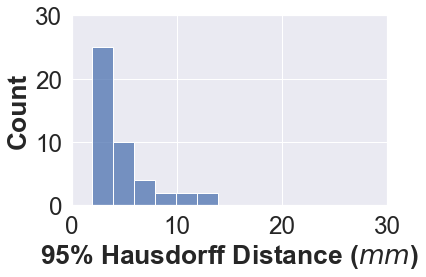

In [269]:
# histogram 95% HD
sns.set_context("paper")
# sns.histplot(hd_df, binwidth=2.5)
sns.set(font_scale = 2.2)
f2b = sns.histplot(results_df['95% Hausdorff Distance (mm)'], binwidth=2)

plt.axis([0, 30, 0, 30])
plt.ylabel('Count',fontweight = 'bold')
plt.xlabel('95% Hausdorff Distance ($mm$)',fontweight = 'bold')
plt.gcf().subplots_adjust(bottom=0.22, left=0.17)

plt.savefig('../output/figures_NeuroImage_clinical/figure_2B.tiff',
           dpi=300)

### Figure 3C

Pearson's corr: R = 0.938716654426957 P = 1.6530112466827892e-21
MAE: 4.160223131471476


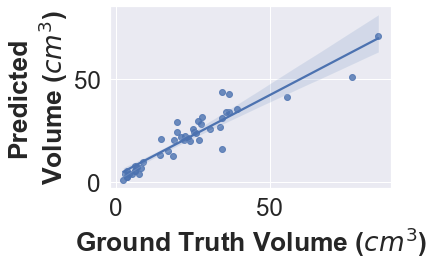

In [270]:
# plot relationship between predicted and ground truth segmentations
sns.set_theme(color_codes=True)
sns.set(font_scale = 2.2)
x, y = pd.Series(gt_vol, name="Ground Truth Volume (cubic cm)"), pd.Series(pred_vol, name="Predicted Volume (cubic cm)")
ax = sns.regplot(x=x, y=y)
r, p = scipy.stats.pearsonr( x, y)
MAE = sklearn.metrics.mean_absolute_error(x, y)
print('Pearson\'s corr: R = '+ str(r) + ' P = ' + str(p) )
print( 'MAE: ' + str(MAE) )

plt.xlabel('Ground Truth Volume ($cm^3$)',fontweight = 'bold')
plt.ylabel('Predicted\nVolume ($cm^3$)',fontweight = 'bold')
plt.gcf().subplots_adjust(bottom=0.25, left=0.25)
plt.savefig('../output/figures_NeuroImage_clinical/figure_2C.tiff',
           dpi=300)

# sns.lineplot(x=[-5,40,85],y=[-5,40,85], dashes=True)
# plt.axis([0, 90, 0, 90])

#### 3.4. False negatives & false positives

The classifier’s false negative and false positive rates of lesion detection were also assessed. A false negative was defined as the algorithm having no segmentation overlap with the manual segmentation. A false positive was defined as inappropriate segmentation in a control subject. For all resection patients, the classifier correctly lateralized their resection to the appropriate hemisphere and the predicted resection overlapped the ground truth label. This indicates a low false negative rate for lesion detection (effectively 0%). To evaluate the potential for false positives, we applied the classifier to 40 control subjects (20 healthy controls and 20 preoperative epilepsy patients with no resection). In 33 control subjects, no resection segmentation was produced. In 5 subjects, less than 50 voxels were segmented, while the remaining 2 subjects had a small volume (less than 0.5 cm3 or 500 voxels) of hypointense temporal lobe tissue segmented (Figure S2). Given the small segmentation sizes, these false positives can be effectively screened out by applying a segmentation size threshold. Importantly, the low false positive rate indicates the classifier is sensitive to the presence of a resection, not simply localizing the temporal lobe and producing an average resection mask as output.

In [276]:
# load data
control_vol = np.load('../analysis/final_results/results/control/volumes.npy')
control_vox = np.load('../analysis/final_results/results/control/voxels.npy')
control_subs = np.load('../analysis/final_results/results/control/patient_list.npy')

# make dataframe
results_df =pd.DataFrame({'subID': control_subs, 
                          'Predicted Volume (ml)': control_vol,
                          'Segmented Voxels': control_vox})
results_df.sort_values(by='Predicted Volume (ml)')

,subID,Predicted Volume (ml),Segmented Voxels
0,PC002_T1,0.000000,0.0
20,con101_01,0.000000,0.0
22,con103_01,0.000000,0.0
23,con104_01,0.000000,0.0
24,con105_01,0.000000,0.0
25,con106_01,0.000000,0.0
26,con107_01,0.000000,0.0
29,con110_01,0.000000,0.0
30,pat02,0.000000,0.0
31,pat03,0.000000,0.0


#### 3.5. Lesion size relationships

Previous studies have found a relationship between lesion size and classifier accuracy as measured by DSC and percent volume difference (PVD) between predicted and manual segmentations (30). To understand whether lesion size contributed to classifier accuracy or PVD error, we partitioned subjects into small (N = 17) and large (N = 28) resection groups using the same threshold (﻿﻿17.92 ml) previously reported (25). In our model, we found the average DSC was greater for large resections (large = 0.84, small = 0.79, p = 0.03, t = 2.24, two-sample t-test) and that PVD was higher for small resections (large = 16.3, small = 25.1, p = 0.049, t = 2.02, two-sample t-test), both of which indicate a larger error for smaller resection segmentations. Predicted and actual volumes for small resections were not significantly different (mean volume: actual = 7.2 ml, predicted = 6.9 ml, p = 0.63, t = 0.49, two-sample t-test), however large resections tended towards under-segmentation (mean volume: actual = 32.5 ml, predicted = 29.5 ml, p = 0.050, t = 2.05, two-sample t-test).


In [271]:
# calculate absolute partial volume difference
results_df['PVD'] = np.multiply( np.abs( (results_df['Ground Truth Volume (ml)'] - results_df['Predicted Volume (ml)']) ) / results_df['Ground Truth Volume (ml)'] , 100)

# define small and large groups using threshold form Gau et al., 2020 (25)
large = results_df[ results_df['Ground Truth Volume (ml)'] >= 17.92 ]
small = results_df[ results_df['Ground Truth Volume (ml)'] < 17.92 ]

# compare small/large DSC
print('Large DSC: ' + str( np.round( np.mean( large['Dice Score'] ) , 2) ) + ' +/- ' + str( np.round( np.std( large['Dice Score']) , 2) ) )
print('Small DSC: ' + str( np.round( np.mean( small['Dice Score'] ) , 2) ) + ' +/- ' + str( np.round( np.std( small['Dice Score']) , 2) ) )
DSC_size_results = scipy.stats.ttest_ind( large['Dice Score'], small['Dice Score'])
print(DSC_size_results)
print(' ')

# compare small/large Percent Volume Difference (PVD)
print('Large PVD: ' + str( np.round( np.mean( large['PVD'] ) , 2) ) + ' +/- ' + str( np.round( np.std( large['PVD']) , 2) ) )
print('Small PVD: ' + str( np.round( np.mean( small['PVD'] ) , 2) ) + ' +/- ' + str( np.round( np.std( small['PVD']) , 2) ) )
PVD_result = scipy.stats.ttest_ind( large['PVD'], small['PVD'])
print( PVD_result )
print(' ')

# compare large lesions volume estimates
print('Large resection volume (actual): ' + str( np.round( np.mean( large['Ground Truth Volume (ml)'] ) , 2 ) ) + ' +/- ' + str( np.round( np.std( large['Ground Truth Volume (ml)']) , 2) ) )
print('Large resection volume (predicted): ' + str( np.round( np.mean( large['Predicted Volume (ml)'] ) , 2 ) ) + ' +/- ' + str( np.round( np.std( large['Predicted Volume (ml)']) , 2) ) )
LRV_results = scipy.stats.ttest_rel(large['Ground Truth Volume (ml)'], large['Predicted Volume (ml)'])
print(LRV_results)
print(' ')

# compare small lesions volume estimates
print('Small resection volume (actual): ' + str( np.round( np.mean( small['Ground Truth Volume (ml)'] ) , 2 ) ) + ' +/- ' + str( np.round( np.std( small['Ground Truth Volume (ml)']) , 2) ) )
print('Small resection volume (predicted): ' + str( np.round( np.mean( small['Predicted Volume (ml)'] ) , 2 ) ) + ' +/- ' + str( np.round( np.std( small['Predicted Volume (ml)']) , 2) ) )
SRV_results = scipy.stats.ttest_rel(small['Ground Truth Volume (ml)'], small['Predicted Volume (ml)'])
print(SRV_results)
print(' ')


Large DSC: 0.84 +/- 0.07
Small DSC: 0.79 +/- 0.07
Ttest_indResult(statistic=2.244045508520422, pvalue=0.030031159712172895)
 
Large PVD: 16.28 +/- 13.22
Small PVD: 25.12 +/- 14.91
Ttest_indResult(statistic=-2.0238491535253105, pvalue=0.0492277692797012)
 
Large resection volume (actual): 32.52 +/- 15.64
Large resection volume (predicted): 29.48 +/- 11.78
Ttest_relResult(statistic=2.0481085461774837, pvalue=0.050388292387232796)
 
Small resection volume (actual): 7.17 +/- 4.21
Small resection volume (predicted): 6.92 +/- 4.99
Ttest_relResult(statistic=0.4902410547220481, pvalue=0.6306179833331536)
 


#### 3.6. Held-out test set performance

In addition to the held-out test sets used in the cross-validation approach, we compiled a separate held-out set containing 17 TLE patients after model development. We evaluated model performance on this test set using the same metrics used in the cross-validation set. Model performance decreased slightly in the held-out test set (Table 2). The median DSC was 0.74 with an interquartile range of 0.22 (Figure 4A), compared to 0.84 ± 0.06 in the cross-validation set. The median 95% Hausdorff distance increased from 3.61 ± 2.64 mm (median ± interquartile range) to 4.04 ± 10.32 mm (Figure 4B). The comparison of predicted and manually segmented volumes remained similar between the two sets (cross-validation: r = 0.94, p < 0.0001, held-out test set: r = 0.87, p < 0.0001). Examples comparing the manual and automated segmentations from throughout the DSC distribution are seen in Figure 4D. Although model performance decreased slightly in the held-out test set, it is important to note that inclusion criteria were relaxed for the held-out test set to increase the sample size, which may have impacted our results.

#### 3.6. Held-out test set performance

In addition to the held-out test sets used in the cross-validation approach, we compiled a separate held-out set containing 17 TLE patients after model development. We evaluated model performance on this test set using the same metrics used in the cross-validation set. Model performance decreased slightly in the held-out test set (Table 2). The median DSC was 0.74 with an interquartile range of 0.22 (Figure 4A), compared to 0.84 ± 0.06 in the cross-validation set. The median 95% Hausdorff distance increased from 3.61 ± 2.64 mm (median ± interquartile range) to 4.04 ± 10.32 mm (Figure 4B). The comparison of predicted and manually segmented volumes remained similar between the two sets (cross-validation: r = 0.94, p < 0.0001, held-out test set: r = 0.87, p < 0.0001). Examples comparing the manual and automated segmentations from throughout the DSC distribution are seen in Figure 4D. Although model performance decreased slightly in the held-out test set, it is important to note that inclusion criteria were relaxed for the held-out test set to increase the sample size, which may have impacted our results.

In [235]:
# get volumes of predicted and actual resection segmentations
gt_vol = []
pred_vol = []
subs = np.load('../analysis/final_results/results/test/patient_list.npy')
for sub in subs:
    
    # read in resection segmentations
    filepath = '../analysis/final_results/holdout_test/' + sub + '/resection_mask.nii.gz'
    GT = ants.image_read(filepath)
    filepath = '../analysis/final_results/holdout_test/' + sub + '/predicted_mask_majority_vote_2.nii.gz'
    pred = ants.image_read(filepath)
    
    # calculate voxel volume
    voxel_volume = GT.spacing[0] * GT.spacing[1] * GT.spacing[2]
    
    # store volume in array
    gt_vol.append( np.sum( GT.numpy() == 1 ) * voxel_volume / 1000 )
    pred_vol.append( np.sum( pred.numpy() == 1 ) * voxel_volume / 1000)

In [236]:
# load data
dice = np.load('../analysis/final_results/results/test/dice_scores.npy')
hd50 = np.load('../analysis/final_results/results/test/hd50.npy')
hd95 = np.load('../analysis/final_results/results/test/hd95.npy')

# make dataframe
results_df =pd.DataFrame({'subID': subs, 
                          'Predicted Volume (ml)': pred_vol,
                          'Ground Truth Volume (ml)': gt_vol,
                          'Dice Score': dice,
                          '50% Hausdorff Distance (mm)': hd50,
                          '95% Hausdorff Distance (mm)': hd95})
results_df.sort_values(by='Dice Score')

,subID,Predicted Volume (ml),Ground Truth Volume (ml),Dice Score,50% Hausdorff Distance (mm),95% Hausdorff Distance (mm)
9,pat107_02,0.207267,2.419438,0.153263,9.470092,28.039828
0,RID0024,6.763000,25.679169,0.414453,4.032219,13.324571
15,pat38_03,2.293000,3.352000,0.511957,1.732051,24.103942
14,pat37_02,3.095915,5.429559,0.557971,1.412952,21.087859
16,pat39_02,2.009000,2.372000,0.608993,1.000000,26.095977
11,pat34_03,4.162000,2.593000,0.701110,1.000000,3.000000
4,pat102_03,20.234397,12.002527,0.715836,1.000000,6.696366
12,pat35_03,4.924000,4.661000,0.734690,1.000000,6.082763
5,pat103_03,5.317000,4.875000,0.744702,1.000000,4.000000
6,pat104_03,4.863789,4.251954,0.759948,0.998235,4.238899


Dice Score
Mean (std): 0.69 +/- 0.19
Median (IQR): 0.74 +/- 0.22
Max: 0.92
Min: 0.15



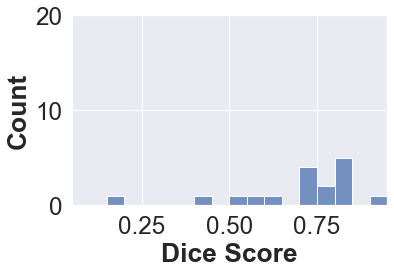

In [237]:
# histogram distribution of DSC
sns.set_context("paper")
sns.set(font_scale = 2.2)
ax = sns.histplot(results_df['Dice Score'],binwidth=0.05, binrange=[0.05,.95])
plt.axis([0.05, 0.95 , 0, 20])
plt.ylabel('Count',fontweight = 'bold')
plt.xlabel('Dice Score',fontweight = 'bold')
plt.gcf().subplots_adjust(bottom=0.22, left=0.17)
plt.savefig('../output/figures_NeuroImage_clinical/figure_heldoutA.tiff',
           dpi=300)

# print DSC basic stats
basic_stats(results_df,'Dice Score')

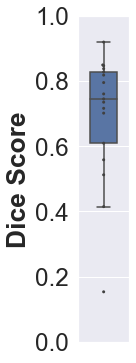

In [238]:
# boxplot of DSC
sns.set(font_scale = 2.2)
fig = plt.figure(figsize = (2,6)) # create a 5 x 5 figure 
ax = sns.boxplot(y="Dice Score", data=results_df, orient="v", fliersize=0)
ax = sns.swarmplot(y="Dice Score", data=results_df, orient="v", color=".25", size=3)
plt.axis([-0.75,0.75,0,1])


plt.ylabel('Dice Score',fontweight = 'bold')
plt.gcf().subplots_adjust(left=0.55)
plt.savefig('../output/figures_NeuroImage_clinical/figure_heldoutD.tiff',
           dpi=600)

In [239]:
# print DSC basic stats
basic_stats(results_df,'50% Hausdorff Distance (mm)')
basic_stats(results_df,'95% Hausdorff Distance (mm)')
basic_stats(results_df,'Ground Truth Volume (ml)')
basic_stats(results_df,'Predicted Volume (ml)')

# # compare predicted and ground truth volumes
print('T-test: predicted versus GT volume')
scipy.stats.ttest_rel( results_df['Predicted Volume (ml)'], results_df['Ground Truth Volume (ml)'])

50% Hausdorff Distance (mm)
Mean (std): 1.61 +/- 2.13
Median (IQR): 1.0 +/- 0.0
Max: 9.47
Min: 0.0

95% Hausdorff Distance (mm)
Mean (std): 9.33 +/- 9.03
Median (IQR): 4.04 +/- 10.32
Max: 28.04
Min: 2.23

Ground Truth Volume (ml)
Mean (std): 10.89 +/- 10.69
Median (IQR): 6.01 +/- 7.75
Max: 37.8
Min: 2.37

Predicted Volume (ml)
Mean (std): 10.17 +/- 10.05
Median (IQR): 6.76 +/- 3.99
Max: 37.57
Min: 0.21

T-test: predicted versus GT volume


Ttest_relResult(statistic=-0.5340855473912228, pvalue=0.6006250456493685)

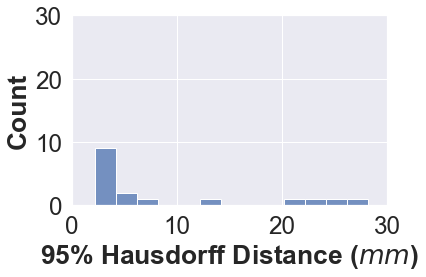

In [240]:
# histogram 95% HD
sns.set_context("paper")
# sns.histplot(hd_df, binwidth=2.5)
sns.set(font_scale = 2.2)
f2b = sns.histplot(results_df['95% Hausdorff Distance (mm)'], binwidth=2)

plt.axis([0, 30, 0, 30])
plt.ylabel('Count',fontweight = 'bold')
plt.xlabel('95% Hausdorff Distance ($mm$)',fontweight = 'bold')
plt.gcf().subplots_adjust(bottom=0.22, left=0.17)

plt.savefig('../output/figures_NeuroImage_clinical/figure_heldoutB.tiff',
           dpi=300)

Pearson's corr: R = 0.8688303700583381 P = 6.029440423568879e-06
MAE: 2.981796630908833


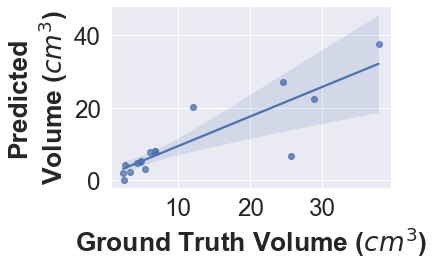

In [241]:
# plot relationship between predicted and ground truth segmentations
sns.set_theme(color_codes=True)
sns.set(font_scale = 2.2)
x, y = pd.Series(gt_vol, name="Ground Truth Volume (cubic cm)"), pd.Series(pred_vol, name="Predicted Volume (cubic cm)")
ax = sns.regplot(x=x, y=y)
r, p = scipy.stats.pearsonr( x, y)
MAE = sklearn.metrics.mean_absolute_error(x, y)
print('Pearson\'s corr: R = '+ str(r) + ' P = ' + str(p) )
print( 'MAE: ' + str(MAE) )

plt.xlabel('Ground Truth Volume ($cm^3$)',fontweight = 'bold')
plt.ylabel('Predicted\nVolume ($cm^3$)',fontweight = 'bold')
plt.gcf().subplots_adjust(bottom=0.25, left=0.25)
plt.savefig('../output/figures_NeuroImage_clinical/figure_heldoutC.tiff',
           dpi=300)

# sns.lineplot(x=[-5,40,85],y=[-5,40,85], dashes=True)
# plt.axis([0, 90, 0, 90])

#### 3.7. Comparing surgical approaches

Next, we compared the algorithm’s performance between patients treated with SAH (N = 14) and ATL (N = 29) to determine if one surgical approach accounted for a greater degree of model error. Patients treated with LITT were excluded from statistical analysis, as only two patients were in this group. There was no significant difference in our primary performance measure, DSC (ATL: 0.83 ± 0.07, SAH: 0.81 ± 0.06, mean ± standard deviation, p = 0.25, t = 1.15). Patients treated with LITT had slightly lower DSC (0.61 and 0.74), possibly caused by the low number of training samples and hyperintense coagulative necrosis in ablation cavities (34). There was no difference in the 95% Hausdorff distance between ATL and SAH groups (ATL: 4.5 ± 2.0 mm, SAH: 4.2 ± 2.9 mm, mean ± standard deviation, p = 0.71, t = 0.37). As expected, both the ground truth volumes (ATL: 29.2 ± 13.7 cm3, SAH: 7.2 ± 3.9 cm3, mean ± standard deviation, p < 0.001, t = 5.66) and predicted volumes (ATL: 27.6 ± 11.1 cm3, SAH: 6.7 ± 3.4 cm3, mean ± standard deviation, p < 0.001, t = 6.63) were significantly larger for patients treated with ATL.

In [272]:
# get SAH and ATL dataframes
combined_df = results_df.merge(demo_df, left_on='subID', right_on='ID')
SAH_df = combined_df[ combined_df['surgery'] == 'SAH' ]
ATL_df = combined_df[ combined_df['surgery'] == 'ATL' ]

# compare DSC
compare_stats(ATL_df,'ATL',SAH_df,'SAH','Dice Score')
compare_stats(ATL_df,'ATL',SAH_df,'SAH','50% Hausdorff Distance (mm)')
compare_stats(ATL_df,'ATL',SAH_df,'SAH','95% Hausdorff Distance (mm)')
compare_stats(ATL_df,'ATL',SAH_df,'SAH','Ground Truth Volume (ml)')
compare_stats(ATL_df,'ATL',SAH_df,'SAH','Predicted Volume (ml)')


Dice Score
ATL
Mean (std): 0.83 +/- 0.07
Median (IQR): 0.85 +/- 0.06
Max: 0.91
Min: 0.58
SAH
Mean (std): 0.81 +/- 0.06
Median (IQR): 0.83 +/- 0.08
Max: 0.89
Min: 0.66
Ttest_indResult(statistic=1.1512966003267049, pvalue=0.25764243115548857)

50% Hausdorff Distance (mm)
ATL
Mean (std): 0.8 +/- 0.4
Median (IQR): 0.98 +/- 0.02
Max: 1.38
Min: 0.0
SAH
Mean (std): 0.64 +/- 0.48
Median (IQR): 1.0 +/- 1.0
Max: 1.0
Min: 0.0
Ttest_indResult(statistic=1.0461618176173781, pvalue=0.30286712986678477)

95% Hausdorff Distance (mm)
ATL
Mean (std): 4.52 +/- 1.99
Median (IQR): 4.0 +/- 2.27
Max: 10.88
Min: 2.23
SAH
Mean (std): 4.2 +/- 2.87
Median (IQR): 3.08 +/- 1.47
Max: 12.08
Min: 2.0
Ttest_indResult(statistic=0.3721209444600992, pvalue=0.7121121972637512)

Ground Truth Volume (ml)
ATL
Mean (std): 29.15 +/- 13.73
Median (IQR): 26.22 +/- 10.69
Max: 85.35
Min: 14.69
SAH
Mean (std): 7.24 +/- 3.86
Median (IQR): 6.29 +/- 3.45
Max: 17.01
Min: 2.88
Ttest_indResult(statistic=5.659683231643311, pvalue=2.3844540

#### 3.8. Visual inspection

The largest sources of segmentation error were small resection volumes, hyperintense material in the resection cavity, surgical tracts, boundaries between resections and ventricles, and resections that extended into parietal regions. The relationship between resection size and segmentation accuracy is detailed in section 3.5 Lesion size relationships. Hyperintense material in the resection cavity (e.g. blood products, LITT coagulative necrosis (34), and residual tissue fragments) were included in manual resections but sometimes ignored by the classifier (Figure 5A). There were two examples of patients treated with LITT (DSC: 0.61 and 0.74), and the hyperintense material was not segmented in both cases. In patients treated with SAH, the surgical tracts were included in manual segmentations but ignored in some automated segmentations (Figure 5B). Additional sources of error included atypical resections that extended posteriorly and difficulty delineating the boundary of resections adjacent to the lateral ventricles (Figure S3).

#### 3.9. Model tuning to extratemporal cases

The model tuned using extratemporal cases was able to segment the resection site in 5 of 6 test set patients, with one frontal lobe resection missed (Figure S4D). Resection segmentation was at least partially successful in the remaining subjects, with a median DSC of 0.75 ± 0.23 (Figure S4A). In one subject with non-contiguous frontal and temporal lobe resections, only the frontal lobe resection was segmented (Figure S4D). The median 95% Hausdorff distance was 10.35 ± 32.59 mm (median ± interquartile range) (Figure S4B). A similar relationship between predicted and actual volumes was seen in this limited dataset (r = 0.80, p = 0.054, Figure S4C). Example of all test set segmentations can be seen in Figure S4D. We do not recommend using the model weights from this exploratory analysis but offer this as preliminary evidence that the classifier can be tuned to work with extratemporal resections given sufficient data.

In [242]:
import json

def load_json_test(filename,key):

    f = open(filename)
    data = json.load(f)
    return data[key]

In [243]:
# get volumes of predicted and actual resection segmentations
gt_vol = []
pred_vol = []
subs = load_json_test('../analysis/final_results/results/tune/patients_by_fold.json','test')
for sub in subs:
    
    # read in resection segmentations
    filepath = '../analysis/final_results/extratemporal/' + sub + '/resection_mask.nii.gz'
    GT = ants.image_read(filepath)
    filepath = '../analysis/final_results/extratemporal/' + sub + '/predicted_mask_majority_vote_2.nii.gz'
    pred = ants.image_read(filepath)
    
    # calculate voxel volume
    voxel_volume = GT.spacing[0] * GT.spacing[1] * GT.spacing[2]
    
    # store volume in array
    gt_vol.append( np.sum( GT.numpy() == 1 ) * voxel_volume / 1000 )
    pred_vol.append( np.sum( pred.numpy() == 1 ) * voxel_volume / 1000)
    


In [244]:
# load data
dice = load_json_test('../analysis/final_results/results/tune/dice_by_fold_majority_vote_2.json','test')
hd50 = load_json_test('../analysis/final_results/results/tune/hd50_by_fold_majority_vote_2.json','test')
hd95 = load_json_test('../analysis/final_results/results/tune/hd95_by_fold_majority_vote_2.json','test')

# make dataframe
results_df =pd.DataFrame({'subID': subs, 
                          'Predicted Volume (ml)': pred_vol,
                          'Ground Truth Volume (ml)': gt_vol,
                          'Dice Score': dice,
                          '50% Hausdorff Distance (mm)': hd50,
                          '95% Hausdorff Distance (mm)': hd95})
results_df.sort_values(by='Dice Score')

,subID,Predicted Volume (ml),Ground Truth Volume (ml),Dice Score,50% Hausdorff Distance (mm),95% Hausdorff Distance (mm)
5,RID0139,0.000000,12.820244,0.000000,inf,inf
3,RID0042,49.025536,107.178688,0.585206,3.154944,45.941105
0,RID0014,10.370777,10.662455,0.716782,1.270582,7.831946
2,RID0020,25.448799,23.074150,0.778420,0.976562,12.873495
1,RID0016,31.248280,33.289101,0.870888,0.000000,4.165877
4,RID0063,62.260628,63.468933,0.906984,0.976562,3.547262


Dice Score
Mean (std): 0.64 +/- 0.31
Median (IQR): 0.75 +/- 0.23
Max: 0.91
Min: 0.0



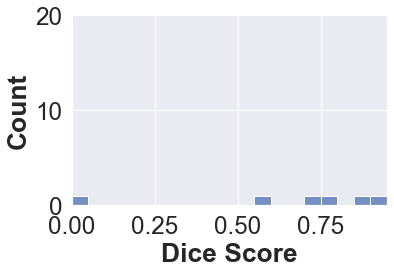

In [245]:
# histogram distribution of DSC
sns.set_context("paper")
sns.set(font_scale = 2.2)
ax = sns.histplot(results_df['Dice Score'],binwidth=0.05, binrange=[0,.95])
plt.axis([0, 0.95 , 0, 20])
plt.ylabel('Count',fontweight = 'bold')
plt.xlabel('Dice Score',fontweight = 'bold')
plt.gcf().subplots_adjust(bottom=0.22, left=0.17)
plt.savefig('../output/figures_NeuroImage_clinical/figure_extratemporalA.tiff',
           dpi=300)

# print DSC basic stats
basic_stats(results_df,'Dice Score')

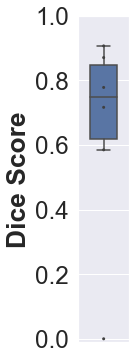

In [246]:
# boxplot of DSC
sns.set(font_scale = 2.2)
fig = plt.figure(figsize = (2,6)) # create a 5 x 5 figure 
ax = sns.boxplot(y="Dice Score", data=results_df, orient="v", fliersize=0)
ax = sns.swarmplot(y="Dice Score", data=results_df, orient="v", color=".25", size=3)
plt.axis([-0.75,0.75,-0.01,1])


plt.ylabel('Dice Score',fontweight = 'bold')
plt.gcf().subplots_adjust(left=0.55)
plt.savefig('../output/figures_NeuroImage_clinical/figure_extratemporalD.tiff',
           dpi=600)

In [247]:
# print DSC basic stats
basic_stats(results_df,'50% Hausdorff Distance (mm)')
basic_stats(results_df,'95% Hausdorff Distance (mm)')
basic_stats(results_df,'Ground Truth Volume (ml)')
basic_stats(results_df,'Predicted Volume (ml)')

# # compare predicted and ground truth volumes
print('T-test: predicted versus GT volume')
scipy.stats.ttest_rel( results_df['Predicted Volume (ml)'], results_df['Ground Truth Volume (ml)'])

50% Hausdorff Distance (mm)
Mean (std): inf +/- nan
Median (IQR): 1.12 +/- 1.71
Max: inf
Min: 0.0

95% Hausdorff Distance (mm)
Mean (std): inf +/- nan
Median (IQR): 10.35 +/- 32.59
Max: inf
Min: 3.55

Ground Truth Volume (ml)
Mean (std): 41.75 +/- 34.1
Median (IQR): 28.18 +/- 40.54
Max: 107.18
Min: 10.66

Predicted Volume (ml)
Mean (std): 29.73 +/- 21.25
Median (IQR): 28.35 +/- 30.44
Max: 62.26
Min: 0.0

T-test: predicted versus GT volume


Ttest_relResult(statistic=-1.269682175774731, pvalue=0.26008115012770106)

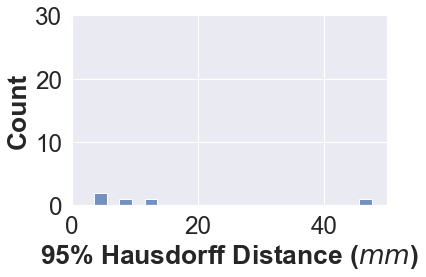

In [248]:
# histogram 95% HD
sns.set_context("paper")
# sns.histplot(hd_df, binwidth=2.5)
sns.set(font_scale = 2.2)
f2b = sns.histplot(results_df['95% Hausdorff Distance (mm)'], binwidth=2)

plt.axis([0, 50, 0, 30])
plt.ylabel('Count',fontweight = 'bold')
plt.xlabel('95% Hausdorff Distance ($mm$)',fontweight = 'bold')
plt.gcf().subplots_adjust(bottom=0.22, left=0.17)

plt.savefig('../output/figures_NeuroImage_clinical/figure_extratemporalB.tiff',
           dpi=300)

Pearson's corr: R = 0.8045204204437639 P = 0.05358354018714351
MAE: 12.81480817634894


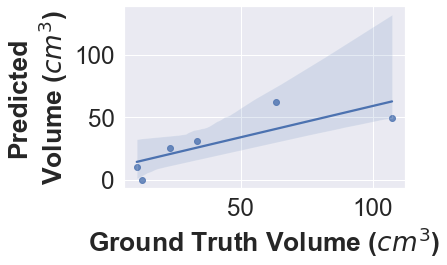

In [249]:
# plot relationship between predicted and ground truth segmentations
sns.set_theme(color_codes=True)
sns.set(font_scale = 2.2)
x, y = pd.Series(gt_vol, name="Ground Truth Volume (cubic cm)"), pd.Series(pred_vol, name="Predicted Volume (cubic cm)")
ax = sns.regplot(x=x, y=y)
r, p = scipy.stats.pearsonr( x, y)
MAE = sklearn.metrics.mean_absolute_error(x, y)
print('Pearson\'s corr: R = '+ str(r) + ' P = ' + str(p) )
print( 'MAE: ' + str(MAE) )

plt.xlabel('Ground Truth Volume ($cm^3$)',fontweight = 'bold')
plt.ylabel('Predicted\nVolume ($cm^3$)',fontweight = 'bold')
plt.gcf().subplots_adjust(bottom=0.25, left=0.25)
plt.savefig('../output/figures_NeuroImage_clinical/figure_extratemporalC.tiff',
           dpi=300)

# sns.lineplot(x=[-5,40,85],y=[-5,40,85], dashes=True)
# plt.axis([0, 90, 0, 90])

#### 3.10. Quantifying surgical remnants

The web application that deploys our pipeline consists of a set of sequential web pages where users can upload pre- and post-operative MR images, visualize the automated segmentation, and save a report estimating resected brain regions to their local desktop. The landing screen lets the user choose between applying the full pipeline to their data using our automated segmentation algorithm or uploading a manually generated segmentation and visualizing the report. The full pipeline consists of pre- and post-operative image registration (18), pre-operative segmentation using the DKT brain atlas with subcortical structures (32), and resection segmentation using our described model. The report page consists of a table listing affected brain regions, a 3D resection mask viewer, and optional user feedback (Figure 6). The report table provides the total resection volume and lists affected brain regions by percentage resected. An embedded 3D mask viewer allows the user to make a quality assessment of the predicted mask against the post-operative image. To assess the feasibility of deploying the full pipeline to users, we computed the time elapsed for running the web application. The average run time was 4 minutes and 19 seconds, and all run times were less than 5 minutes. A detailed user manual for running the web application can be found in the GitHub repository.

Hippocampal remnants have previously been associated with worse surgical outcomes (12). We compared hippocampal remnant volumes using the manual and predicted resection segmentations for a subset of 36 patients with available preoperative imaging. One subject was excluded due to poor image registration. Figure 7 illustrates the correlation between hippocampal remnant estimates made using the manual labels and automated segmentation (r = 0.90, p < 0.0001, mean absolute error = 6.3%).


In [2]:
# Segment preop images using DKT atlas
for folder in os.listdir('../analysis/CFM_results/'):
    
    # ignore .DS_Store
    if folder == '.DS_Store':
        continue 
    # ignore subject 15_e (no resection mask)
    if folder == '15_e':
        continue 
        
    # skip if already processed
    filename = '../../DeepResection/analysis/CFM_results/' + folder + '/atlas2pre/DKT_DL.nii.gz'
    if os.path.exists(filename):
        continue
    
    # load pre2post image
    if folder[:3] == 'pat':
        filename = '../../DeepResection/analysis/CFM_results/' + folder + '/pre2post/pre2post_T1W3D-0001_pre_' + folder + '.nii'
    else:
        filename = '../../DeepResection/analysis/CFM_results/' + folder + '/pre2post/pre2post_' + folder + '_preop.nii.gz' 
    preop = ants.image_read(filename)
        
    # DKT segmentation
    DKT = antspynet.utilities.desikan_killiany_tourville_labeling(preop, do_preprocessing=True, return_probability_images=False, do_lobar_parcellation=False, antsxnet_cache_directory=None, verbose=False)
    filename = '../../DeepResection/analysis/CFM_results/' + folder + '/atlas2pre/DKT_DL.nii.gz'
    ants.image_write(DKT, filename)

/Users/tcarnold/Desktop/Everything/CNT/Projects/DeepResection/scripts
Pearson's corr: R = 0.9022735169883203 P = 1.3318953818157718e-13
MAE: 0.06264736016960967


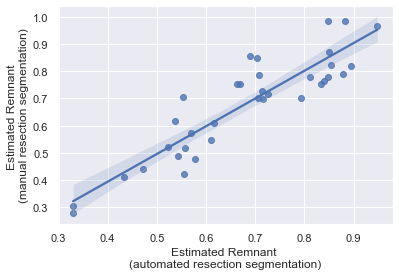

In [275]:
# load in real and predicted volumes
HIPP_vols_df = lesion_df = pd.DataFrame(columns=['sub_ID','prior_vol','vol_gt', 'vol_pred','per_gt','per_pred'])
print(os.getcwd())
for folder in os.listdir('../analysis/CFM_results/'):
    
    # ignore .DS_Store
    if folder == '.DS_Store':
        continue 
    # ignore subject 15_e (no resection mask)
    if folder == '15_e':
        continue
    # ignore subject 30_m (failed registration pipeline)
    if folder == '30_m':
        continue
        
    # load in masks and atlas
    filename = '../analysis/final_results/nii_FINAL/' + folder + '/resection_mask.nii.gz'
    mask_gt = ants.image_read(filename)
    filename = '../analysis/CFM_results/' + folder + '/manual/atlas2post/atlas2post_AAL116_origin_MNI_T1.nii'
    atlas_gt = ants.image_read(filename)
    filename = '../analysis/final_results/nii_FINAL/' + folder + '/predicted_mask_majority_vote_2.nii.gz'
    mask_pred = ants.image_read(filename)
    filename = '../analysis/CFM_results/' + folder + '/atlas2pre/DKT_DL.nii.gz'
    atlas_pred = ants.image_read(filename)
    
    # determine if left or right resection (see if resection mask intersects left hippocampus)
    L_vol = np.sum( np.multiply( mask_gt.numpy(), atlas_pred.numpy() ) == 17  )
    if L_vol:
        ROI_num = 17
    else:
        ROI_num = 53
    prior_vol = np.sum( atlas_pred.numpy() == ROI_num )
    
    # get binary mask of only the surgical side hippocampus
    preop_hipp = np.multiply( np.ones( np.shape( atlas_pred.numpy() ) ), atlas_pred.numpy() == ROI_num)
    
    # calculate resected hippocampus volumes
    resected_vol_gt = np.sum( np.multiply( mask_gt.numpy(), preop_hipp ) )
    resected_vol_pred = np.sum( np.multiply( mask_pred.numpy(), preop_hipp) )
    
    # calculate hippocampal remnant volume
    vol_gt = prior_vol - resected_vol_gt
    per_gt = (prior_vol - resected_vol_gt) / prior_vol
    vol_pred = prior_vol - resected_vol_pred
    per_pred = (prior_vol - resected_vol_pred) / prior_vol
    
    HIPP_vols_df = HIPP_vols_df.append({'sub_ID': folder,
                                        'prior_vol': prior_vol,
                                        'vol_gt': vol_gt,
                                        'vol_pred': vol_pred,
                                        'per_gt': per_gt,
                                        'per_pred': per_pred}, 
                                       ignore_index=True)
    
    ### save out Hippocampus and DL remnant ###
    # DL remnant
    inv_mask_pred = np.ones( np.shape( mask_pred.numpy() ) ) -  mask_pred.numpy()
    hipp_img_pred = np.multiply( inv_mask_pred, preop_hipp)
    filename = '../analysis/CFM_results/' + folder + '/atlas2post/hipp_renmant.nii.gz'
    img = ants.from_numpy(hipp_img_pred, origin=atlas_pred.origin, spacing=atlas_pred.spacing, \
                    direction=atlas_pred.direction)
    ants.image_write(img, filename)
    # DL preop hippocampus
    filename = '../analysis/CFM_results/' + folder + '/atlas2pre/hipp_preop.nii.gz'
    img = ants.from_numpy( preop_hipp, origin=atlas_pred.origin, spacing=atlas_pred.spacing, \
                    direction=atlas_pred.direction)
    ants.image_write(img, filename)

HIPP_vols_df

# plot relationship between percent of hippocampus remaining for predicted and ground truth segmentations
sns.set_theme(color_codes=True)
x, y = pd.Series(HIPP_vols_df['per_pred'], name="Estimated Remnant \n(automated resection segmentation)"), pd.Series(HIPP_vols_df['per_gt'], name="Estimated Remnant \n(manual resection segmentation)")
ax = sns.regplot(x=x, y=y)
r, p = scipy.stats.pearsonr( x, y)
MAE = sklearn.metrics.mean_absolute_error(HIPP_vols_df['per_gt'], HIPP_vols_df['per_pred'])
print('Pearson\'s corr: R = '+ str(r) + ' P = ' + str(p) )
print( 'MAE: ' + str(MAE) )
plt.savefig('../output/figures_NeuroImage_clinical/figure_6.tiff',
           dpi=300)

## 4. Discussion

We present a deep-learning method to fully automate resection cavity segmentation in postoperative temporal lobe epilepsy patients. Fully automated segmentation provides significant time advantages over manual and semi-automated methods (17,21,35). Our method has several key advantages. First, we trained our model explicitly on TLE patients, who are most frequently operated on for drug-resistant epilepsy. Second, our resection labels are based on gold standard clinical practice (manually segmented by a neuroradiologist with 8 years of experience and subspecialization in epilepsy imaging). Third, we included multi-site data from two epilepsy centers, thus demonstrating potential for multi-center studies. Fourth, by employing an ensemble of 2D CNNs trained on different views of the brain, our segmentation algorithm utilizes the whole 3D volume without using an explicitly 3D model. 3D CNNs learn exponentially more parameters than 2D CNNs, so compared to 3D CNNs, our algorithm avoids high computational training costs and can learn better on modestly sized training datasets. Fifth, we provide a fast method for volumetric analysis of resected brain regions for post-hoc analysis. Sixth, we incorporate a graphical user interface (GUI) for easy interpretation of segmentation quality. We demonstrate the clinical utility of our algorithm by quantifying postoperative remnant structures, which have been shown to predict long-term surgical outcome.

One advantage of the present study is epilepsy patient data was used during model training. A previous study applied lesion_GNB, a stroke segmentation classifier, to the resection cavity segmentation problem in epilepsy patients (30,36). While lesion_GNB demonstrated some utility in segmenting resections (median DSC 0.58), our classifier achieved greater segmentation accuracy. The discrepancy in classifier performance may be caused in part by differences in features between the pathologies, such as lesion intensity and surrounding edema. Resection cavity segmentation has also been attempted in glioblastoma multiforme (GBM) patients (37). Here the classifier was trained explicitly on GBM patient data and classifier performance (median DSC 0.83) was similar to trained radiation oncologists (median DSC 0.85). These studies highlight the importance of developing disease specific classifiers or applying transfer learning to fine-tune models for specific pathologies (38).

Other approaches to boost classifier performance include the incorporation of simulated training data. Pérez-García et al. recently reported the development of EPISURG, a self-supervised resection segmentation classifier that uses exclusively simulated resection data (33). Their classifier achieved a median DSC of 0.805 using 2074 simulated resections, which surpassed their classifier trained using 133 manual labels (median DSC 0.653). This illustrates the significant performance gains possible through innovative data augmentation. However, it is important to note that all versions of their model report false negatives, meaning in some subjects the resection was entirely missed. This is likely due in part to broad inclusion criteria, but false negatives may also be occurring because important features such as gliosis, blood products and brain shift are not included in simulated data.

Researchers have also explored automated methods for resection zone segmentation that do not rely on machine learning. Casseb et al. developed ResectVol (39), an SPM-based program that relies on differences in tissue probability maps between preoperative and postoperative images to identify the resection site and estimate removed brain structures. The authors achieved promising results, with a median DSC of 0.77 and significant correlation between automated and manual resection volumes (r = 0.8, p < 0.001). However, conventional image analysis approaches require longer processing times and may be less resilient to contrast changes associated with ancillary pathology, such as gliosis and edema, or different surgical approaches, such as LITT.

Automating quantification of resected tissue can catalyze progress in at least four fields of epilepsy and neuroimaging research. First, automated resection segmentation can be used to predict brain network reorganization after surgery. Many patients who are initially seizure free after surgery have a seizure relapse in the long term, possibly due to changes in the networks over time (6). Quantifying brain structures remaining after surgery, by reliably delineating tissues resected, is crucial in predicting such changes and determining patients who are likely to have late recurrences (6,40). Second, modeling proposed surgeries improves prediction of surgical outcomes (9,41). Precise delineation of resected tissue would facilitate retrospectively analyzing factors associated with seizure outcomes after surgery. Third, our clinical application protocols can be applied prospectively to quantify network changes for alternate surgical strategies before carrying out an actual surgery (10,15). This is particularly useful for patients who are likely to have poor surgical outcomes or in patients in which the site of resection is close to the eloquent cortex. Finally, surgical resection is known to cause brain shift as cerebral spinal fluid is lost and the resection cavity collapses, leading to positional changes between pre- and post-operative timepoints (42). As such, deformable registration would be required to properly align these images for comparison. However, surgical resection also produces significant errors during deformable registration, resulting in erroneous extrusion of nearby tissue into the resection cavity (33). Our algorithm can be integrated into neuroimaging pipelines to automatically perform cost-function masking of the resection zone, allowing for more accurate processing of postoperative images.

Our study had several limitations, including a use of strict inclusion criteria, poor representation of laser ablations and extratemporal resections, and a single image rater. Our initial approach was to use strict inclusion criteria because a relatively homogenous patient population would likely maximize classifier performance. This limits classifier generalizability to TLE patients and restricts available training data to a smaller sample size. Our dataset size is fairly modest for training deep learning models. However, in future studies, criteria will be relaxed to include patients with resections outside the temporal lobe, different surgical approaches, and a broader range of clinical imaging sequences. Furthermore, laser ablations and extratemporal resection patients were poorly represented in our dataset, which resulted in lower segmentation accuracy for these patients. We have provided a preliminary analysis demonstrating the ability to tune our model to segment extratemporal resections, though a larger sample size will be necessary to produce a robust model. Increasing representation of laser ablations and extratemporal resections, either as actual or simulated data, could improve classification for these patients. An additional study limitation was that manual segmentations were only available from a single neuroradiologist. Having a single rater prevents the assessment of inter-rater reliability (IRR) in our study; however IRR has been assessed for resection segmentation by other groups and results are fairly consistent across studies (median DSC 0.84-0.86) (37,43).

## 5. Conclusion

In conclusion, we developed a fully automated method for segmenting the resection cavity and quantifying brain regions removed in TLE surgical patients. Our method performance approaches IRR between radiologists while significantly reducing manual input and can be deployed in an easy-to-use GUI. Automated resection cavity segmentation methods have important implications for predictive models of surgical interventions and consistency across multi-center trials. We openly share all code and model weights for our classifier to enable acceleration towards clinical translation and improvement of epilepsy patient care.

## References

1. 	Kwan P, Brodie MJ. Early Identification of Refractory Epilepsy. N Engl J Med.  Massachusetts Medical Society ; 2000;342(5):314–319. doi: 10.1056/NEJM200002033420503.
2. 	Asadi-Pooya AA, Stewart GR, Abrams DJ, Sharan A. Prevalence and Incidence of Drug-Resistant Mesial Temporal Lobe Epilepsy in the United States. World Neurosurg. Elsevier Inc.; 2017. p. 662–666. doi: 10.1016/j.wneu.2016.12.074.
3. 	Wiebe S, Blume WT, Girvin JP, Eliasziw M. A Randomized, Controlled Trial of Surgery for Temporal-Lobe Epilepsy. N Engl J Med. Massachusetts Medical Society; 2001;345(5):311–318. doi: 10.1056/NEJM200108023450501.
4. 	Lee SK, Lee SY, Kim K-K, Hong K-S, Lee D-S, Chung C-K. Surgical outcome and prognostic factors of cryptogenic neocortical epilepsy. Ann Neurol. John Wiley & Sons, Ltd; 2005;58(4):525–532. doi: 10.1002/ana.20569.
5. 	Mohammed HS, Kaufman CB, Limbrick DD, et al. Impact of epilepsy surgery on seizure control and quality of life: A 26-year follow-up study. Epilepsia. John Wiley & Sons, Ltd; 2012;53(4):712–720. doi: 10.1111/j.1528-1167.2011.03398.x.
6. 	de Tisi J, Bell GS, Peacock JL, et al. The long-term outcome of adult epilepsy surgery, patterns of seizure remission, and relapse: a cohort study. Lancet. Elsevier; 2011;378(9800):1388–1395. doi: 10.1016/S0140-6736(11)60890-8.
7. 	Cohen-Gadol AA, Wilhelmi BG, Collignon F, et al. Long-term outcome of epilepsy surgery among 399 patients with nonlesional seizure foci including mesial temporal lobe sclerosis. J Neurosurg. American Association of Neurological Surgeons; 2006;104(4):513–524. doi: 10.3171/jns.2006.104.4.513.
8. 	Bonilha L, Keller SS. Quantitative MRI in refractory temporal lobe epilepsy: relationship with surgical outcomes. Quant Imaging Med Surg. 2015;5(2):204–224. doi: 10.3978/j.issn.2223-4292.2015.01.01.
9. 	Koepp MJ, Galovic M, Baudracco I, et al. Association of piriform cortex resection with surgical outcomes in patients with temporal lobe epilepsy. JAMA Neurol. American Medical Association; 2019;76(6):690–700. doi: 10.1001/jamaneurol.2019.0204.
10. 	Taylor PN, Sinha N, Wang Y, et al. The impact of epilepsy surgery on the structural connectome and its relation to outcome. NeuroImage Clin. Elsevier Inc.; 2018;18:202–214. doi: 10.1016/j.nicl.2018.01.028.
11. 	Sinha N, Dauwels J, Kaiser M, et al. Predicting neurosurgical outcomes in focal epilepsy patients using computational modelling. Brain. Oxford University Press; 2017;140(2):319–332. doi: 10.1093/brain/aww299.
12. 	Noulhiane M, Samson S, Clémenceau S, Dormont D, Baulac M, Hasboun D. A volumetric MRI study of the hippocampus and the parahippocampal region after unilateral medial temporal lobe resection. J Neurosci Methods. Elsevier; 2006;156(1–2):293–304. doi: 10.1016/j.jneumeth.2006.02.021.
13. 	Jirsa VK, Proix T, Perdikis D, et al. The Virtual Epileptic Patient: Individualized whole-brain models of epilepsy spread. Neuroimage. Academic Press; 2017;145:377–388. doi: 10.1016/J.NEUROIMAGE.2016.04.049.
14. 	Khambhati AN, Davis KA, Lucas TH, et al. Virtual Cortical Resection Reveals Push-Pull Network Control Preceding Seizure Evolution. Neuron. International Machine Learning Society; 2016;91(5):1170–1182. doi: 10.1016/j.neuron.2016.07.039.
15. 	Kini LG, Bernabei JM, Mikhail F, et al. Virtual resection predicts surgical outcome for drug-resistant epilepsy. Brain. Oxford University Press; 2019;142(12):3892–3905. doi: 10.1093/brain/awz303.
16. 	Yao AD, Cheng DL, Pan I, Kitamura F. Deep Learning in Neuroradiology: A Systematic Review of Current Algorithms and Approaches for the New Wave of Imaging Technology. Radiol Artif Intell. 2020;2(2):e190026. doi: 10.1148/ryai.2020190026.
17. 	Ronneberger O, Fischer P, Brox T. U-Net: Convolutional Networks for Biomedical Image Segmentation. Springer, Cham; 2015. p. 234–241. doi: 10.1007/978-3-319-24574-4_28.
18. 	Tustison NJ, Cook PA, Holbrook AJ, et al. The ANTsX ecosystem for quantitative biological and medical imaging. Sci Rep. NLM (Medline); 2021;11(1):9068. doi: 10.1038/s41598-021-87564-6.
19. 	Chassagnon G, Zacharaki EI, Benmostefa N, Revel M. Deep Learning – based Approach for Automated Assessment of Interstitial Lung Disease in Systemic Sclerosis on CT Images. 2020;(6).
20. 	Duncan JS, Winston GP, Koepp MJ, Ourselin S. Brain imaging in the assessment for epilepsy surgery. Lancet Neurol. Elsevier; 2016;15(4):420–433. doi: 10.1016/S1474-4422(15)00383-X.
21. 	Yushkevich PA, Piven J, Hazlett HC, et al. User-guided 3D active contour segmentation of anatomical structures: Significantly improved efficiency and reliability. Neuroimage. Academic Press; 2006;31(3):1116–1128. doi: 10.1016/J.NEUROIMAGE.2006.01.015.
22. 	Abadi M, Barham P, Chen J, et al. Tensorflow: A system for large-scale machine learning. USENIX Symp Oper Syst Des Implement. 2016;265–283.
23. 	Erickson BJ, Cai J. Magician’s Corner: 4. Image Segmentation with U-Net. Radiol Artif Intell. 2020;2(1):e190161. doi: 10.1148/ryai.2020190161.
24. 	Deng J, Dong W, Socher R, Li L-J, Kai Li, Li Fei-Fei. ImageNet: A large-scale hierarchical image database. Institute of Electrical and Electronics Engineers (IEEE); 2010. p. 248–255. doi: 10.1109/cvpr.2009.5206848.
25. 	Tan M, Le Q V. EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks. PMLR; 2019 May. http://proceedings.mlr.press/v97/tan19a.html. Accessed March 8, 2021.
26. 	Perez L, Wang J. The Effectiveness of Data Augmentation in Image Classification using Deep Learning. 2017; http://arxiv.org/abs/1712.04621. Accessed July 18, 2019.
27. 	Dice LR. Measures of the Amount of Ecologic Association Between Species. Ecology. John Wiley & Sons, Ltd; 1945;26(3):297–302. doi: 10.2307/1932409.
28. 	Maier-Hein L, Eisenmann M, Reinke A, et al. Why rankings of biomedical image analysis competitions should be interpreted with care. Nat Commun. Nature Publishing Group; 2018;9(1). doi: 10.1038/s41467-018-07619-7.
29. 	Bakas S, Reyes M, Jakab A, et al. Identifying the Best Machine Learning Algorithms for Brain Tumor Segmentation, Progression Assessment, and Overall Survival Prediction in the BRATS Challenge. 2018; http://arxiv.org/abs/1811.02629. Accessed July 18, 2019.
30. 	Gau K, Schmidt CSM, Urbach H, et al. Accuracy and practical aspects of semi- and fully automatic segmentation methods for resected brain areas. Neuroradiology. Springer Science and Business Media Deutschland GmbH; 2020;62(12):1637–1648. doi: 10.1007/s00234-020-02481-1.
31. 	Avants, Brian B., Tustison, Nick, Song G. Advanced normalization tools (ANTS). Insight j 2. 2009;1–35.
32. 	Klein A, Tourville J. 101 labeled brain images and a consistent human cortical labeling protocol. Front Neurosci. Frontiers Media SA; 2012;6:171. doi: 10.3389/fnins.2012.00171.
33. 	Brett M, Leff AP, Rorden C, Ashburner J. Spatial normalization of brain images with focal lesions using cost function masking. Neuroimage. Academic Press; 2001;14(2):486–500. doi: 10.1006/nimg.2001.0845.
34. 	LaRiviere MJ, Gross RE. Stereotactic Laser Ablation for Medically Intractable Epilepsy: The Next Generation of Minimally Invasive Epilepsy Surgery. Front Surg. 2016;3(December). doi: 10.3389/fsurg.2016.00064.
35. 	Atsina K-B, Gorniak R, Sharan A, Wu C. A Methodology for Systematic Volumetric Analysis of Perioperative Cranial Imaging in Neurosurgical Patients. JHN J. Thomas Jefferson University; 2016;11(2):2. doi: 10.29046/jhnj.011.2.002.
36. 	Griffis JC, Allendorfer JB, Szaflarski JP. Voxel-based Gaussian naïve Bayes classification of ischemic stroke lesions in individual T1-weighted MRI scans. J Neurosci Methods. Elsevier; 2016;257:97–108. doi: 10.1016/j.jneumeth.2015.09.019.
37. 	Ermiş E, Jungo A, Poel R, et al. Fully automated brain resection cavity delineation for radiation target volume definition in glioblastoma patients using deep learning. Radiat Oncol. BioMed Central Ltd.; 2020;15(1):100. doi: 10.1186/s13014-020-01553-z.
38. 	Pan SJ, Yang Q. A survey on transfer learning. IEEE Trans. Knowl. Data Eng. 2010. p. 1345–1359. doi: 10.1109/TKDE.2009.191.
39. 	Casseb RF, de Campos BM, Morita-Sherman M, et al. ResectVol: A tool to automatically segment and characterize lacunas in brain images. Epilepsia Open. 2021;6(4):720–726. doi: 10.1002/epi4.12546.
40. 	Morgan VL, Rogers BP, Anderson AW, Landman BA, Englot DJ. Divergent network properties that predict early surgical failure versus late recurrence in temporal lobe epilepsy. J Neurosurg. American Association of Neurological Surgeons; 2020;132(5):1324–1333. doi: 10.3171/2019.1.JNS182875.
41. 	Sinha N, Wang Y, Moreira da Silva N, et al. Structural Brain Network Abnormalities and the Probability of Seizure Recurrence After Epilepsy Surgery. Neurology. NLM (Medline); 2021;96(5):e758–e771. doi: 10.1212/WNL.0000000000011315.
42. 	Narasimhan S, Weis JA, Luo M, Simpson AL, Thompson RC, Miga MI. Accounting for intraoperative brain shift ascribable to cavity collapse during intracranial tumor resection. J Med Imaging. 2020;7(03):1. doi: 10.1117/1.jmi.7.3.031506.
43. 	Pérez-García F, Rodionov R, Alim-Marvasti A, Sparks R, Duncan JS, Ourselin S. Simulation of Brain Resection for Cavity Segmentation Using Self-supervised and Semi-supervised Learning. Lect Notes Comput Sci (including Subser Lect Notes Artif Intell Lect Notes Bioinformatics). Springer Science and Business Media Deutschland GmbH; 2020. p. 115–125. doi: 10.1007/978-3-030-59716-0_12.

